# CNN & More
---
## Easy, but Important!

## Keras Update

In [62]:
!pip install --upgrade keras

In [63]:
import os
os.environ['KERAS_BACKEND'] = 'tensorflow'

### Library Loading

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import keras

from keras.backend import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers import RandomRotation, RandomTranslation, RandomFlip, RandomZoom
from keras.callbacks import EarlyStopping

## Data Loading

In [65]:
(train_x, train_y), (test_x, test_y) = keras.datasets.mnist.load_data()

In [66]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


* 데이터 살펴보기

id = 9404
다음 그림은 숫자 9 입니다.


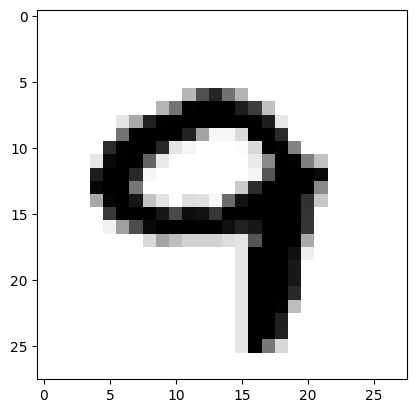

In [67]:
id = np.random.randint(0, 10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y[id]} 입니다.')

plt.imshow(test_x[id], cmap='Greys')
plt.show()

## Data Preprocessing

* Data split
    - training set : validation set = 8 : 2
    - 재현을 위한 난수 고정 : 2024

In [68]:
from sklearn.model_selection import train_test_split

In [69]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=.2, random_state=2024)

* Scaling
    - min-max scaling

In [70]:
max_n, min_n = train_x.max(), train_x.min()

In [71]:
train_x = (train_x - min_n) / (max_n - min_n)
val_x = (val_x - min_n) / (max_n - min_n)
test_x = (test_x - min_n) / (max_n - min_n)

In [72]:
train_x.min(), train_x.max()

(0.0, 1.0)

* One-Hot Encoding

In [73]:
from keras.utils import to_categorical

class_n = len(np.unique(train_y))
class_n

10

In [74]:
train_y = to_categorical(train_y, class_n)
test_y = to_categorical(test_y, class_n)
val_y = to_categorical(val_y, class_n)

* 흑백 정보를 명시하기 위한 reshape

In [75]:
train_x.shape, test_x.shape

((48000, 28, 28), (10000, 28, 28))

In [76]:
train_x = train_x.reshape((-1, 28, 28, 1))
test_x = test_x.reshape((-1, 28, 28, 1))
val_x = val_x.reshape((-1, 28, 28, 1))
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(48000, 28, 28, 1) (48000, 10) (10000, 28, 28, 1) (10000, 10)


In [77]:
val_x.shape

(12000, 28, 28, 1)

## Modeling : CNN

- 조건
    1. Sequential API, Functiona API 중 택일.
    2. Image Augmentation Layer를 최소 하나 이상 넣을 것! : [공식 문서 참고](https://keras.io/api/layers/preprocessing_layers/)
    3. [이 구조를 미니 버전으로 활용해봐도 좋다.](https://img1.daumcdn.net/thumb/R800x0/?scode=mtistory2&fname=https%3A%2F%2Ft1.daumcdn.net%2Fcfile%2Ftistory%2F99DFA5415B38AC752E)
    4. DropOut, BatchNormalization 등의 기능도 같이 활용해보자.
    5. Early Stopping을 사용할 것.

In [78]:
import keras

from keras.utils import clear_session
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, RandomFlip, RandomRotation

* Sequential API

In [86]:
# 1 세션 클리어
clear_session()

# 2 모델 발판 생성
model = Sequential()

# 3 레이어 블록 조립
model.add( Input(shape=(28,28,1)) )
################################
model.add( RandomRotation(0.2) )
################################
model.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( Conv2D(32, (3,3), (1,1), 'same', activation='relu') )
model.add( MaxPool2D((2,2), (2,2)) )
model.add( BatchNormalization() )
model.add( Dropout(0.4) )

model.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( Conv2D(64, (3,3), (1,1), 'same', activation='relu') )
model.add( MaxPool2D((2,2), (2,2)) )
model.add( BatchNormalization() )
model.add( Dropout(0.4) )

model.add( Flatten() )
model.add( Dense(10, activation='softmax') )

# 4 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

* Functional API

In [87]:
# 1 세션 클리어
clear_session()

# 2 레이어 엮기
il = Input(shape=(28,28,1))
##########################
al = RandomRotation(0.2)(il)
##########################
hl = Conv2D(32, (3,3), (1,1), 'same', activation='relu')(al)
hl = Conv2D(32, (3,3), (1,1), 'same', activation='relu')(hl)
hl = MaxPool2D((2,2), (2,2))(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.4)(hl)

hl = Conv2D(32, (3,3), (1,1), 'same', activation='relu')(hl)
hl = Conv2D(32, (3,3), (1,1), 'same', activation='relu')(hl)
hl = MaxPool2D((2,2), (2,2))(hl)
hl = BatchNormalization()(hl)
hl = Dropout(0.4)(hl)

hl = Flatten()(hl)
ol = Dense(10, activation='softmax')(hl)

# 3 시작과 끝 지정
model = Model(il, ol)

# 4 컴파일
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

* Early Stopping

In [81]:
from keras.callbacks import EarlyStopping

In [88]:
es = EarlyStopping(patience=5,
                   verbose=1,
                   restore_best_weights=True)

* **Model Checkpoint**

In [89]:
from keras.callbacks import ModelCheckpoint

In [90]:
mcp = ModelCheckpoint(filepath='./model1.keras',       # 모델 저장 경로
                      monitor='val_loss',              # 모델 저장의 관심 대상
                      verbose=1,                       # 어느 시점에서 저장되는지 알려줌
                      save_best_only=True,             # 최고 성능 모델만 저장
                      save_weights_only=False)         # True : 가중치만 저장 .h5 | False : 모델 구조 포함하여 저장 .keras

* .fit( )

In [91]:
history = model.fit(train_x, train_y, validation_data=(val_x, val_y),
                    epochs=10000, verbose=1,
                    callbacks=[es, mcp])

Epoch 1/10000
1495/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7190 - loss: 0.8977
Epoch 1: val_loss improved from inf to 0.13458, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - accuracy: 0.7195 - loss: 0.8961 - val_accuracy: 0.9576 - val_loss: 0.1346
Epoch 2/10000
1497/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9311 - loss: 0.2232
Epoch 2: val_loss improved from 0.13458 to 0.11219, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9312 - loss: 0.2231 - val_accuracy: 0.9644 - val_loss: 0.1122
Epoch 3/10000
1498/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9454 - loss: 0.1758
Epoch 3: val_loss improved from 0.11219 to 0.08662, saving model to ./model1.keras
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - accuracy: 0.9454 - loss: 0.1758 - val_accuracy: 0.9707 - val_loss: 0.0866
Epoch 4/10000
1496/1500 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9509 - loss: 0.1572
Epoch 4: val_loss improved from

In [92]:
performance_test = model.evaluate(test_x, test_y)

print(f'Test Loss: {performance_test[0]:.6f}')
print(f'Test Accuracy: {performance_test[1]*100:.3f}%')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9814 - loss: 0.0511
Test Loss: 0.049249
Test Accuracy: 98.340%


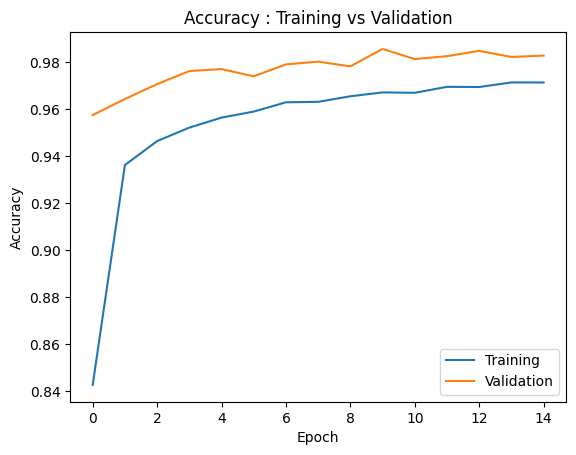

In [93]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('Accuracy : Training vs Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

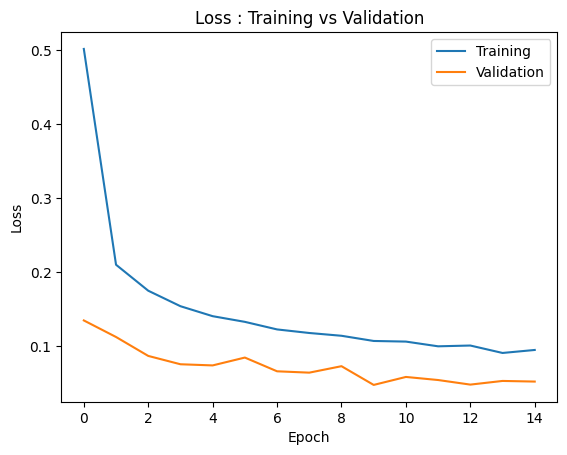

In [94]:
if not isinstance(history, dict):
    history = history.history

plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('Loss : Training vs Validation')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc=0)
plt.show()

## **Model Save & Load**

- .save( )
- .load_model( )

* 모델을 새롭게 저장하여 구조와 가중치 일부를 살펴보자

In [99]:
model.save('./my_first_save.keras')

In [100]:
clear_session()
model3 = keras.models.load_model('./my_first_save.keras')
model3.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          15,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,776 (514.75 KB)

 Trainable params: 43,882 (171.41 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 87,766 (342.84 KB)

In [101]:
model3.get_weights()[0][0][0]

array([[-0.07866161,  0.0043977 , -0.28311622, -0.2538973 ,  0.09657004,
         0.08290128,  0.16794173, -0.06517473, -0.22879186,  0.06666892,
         0.20669398, -0.12316674,  0.0051599 ,  0.08773196,  0.14849548,
        -0.08815715, -0.14806584, -0.00938399,  0.03825066,  0.24438263,
         0.05367576, -0.0359919 ,  0.1314254 ,  0.07937954, -0.06855913,
        -0.13451985, -0.22206812,  0.11291439, -0.14478017,  0.1584395 ,
         0.16479662, -0.27502492]], dtype=float32)

* 학습 과정에서 저장된 모델을 불러와 구조와 가중치 일부를 살펴보자

In [102]:
clear_session()
model = keras.models.load_model('./model1.keras')
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 28, 28, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 28, 28, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 14, 14, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 32)            │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1568)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 10)                  │          15,690 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 131,776 (514.75 KB)

 Trainable params: 43,882 (171.41 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 87,766 (342.84 KB)

In [103]:
model.get_weights()[0][0][0]

array([[-0.07866161,  0.0043977 , -0.28311622, -0.2538973 ,  0.09657004,
         0.08290128,  0.16794173, -0.06517473, -0.22879186,  0.06666892,
         0.20669398, -0.12316674,  0.0051599 ,  0.08773196,  0.14849548,
        -0.08815715, -0.14806584, -0.00938399,  0.03825066,  0.24438263,
         0.05367576, -0.0359919 ,  0.1314254 ,  0.07937954, -0.06855913,
        -0.13451985, -0.22206812,  0.11291439, -0.14478017,  0.1584395 ,
         0.16479662, -0.27502492]], dtype=float32)

* .predict( )

In [104]:
pred_train = model.predict(train_x)
pred_test = model.predict(test_x)

single_pred_train = pred_train.argmax(axis=1)
single_pred_test = pred_test.argmax(axis=1)

logi_train_accuracy = accuracy_score(train_y.argmax(axis=1), single_pred_train)
logi_test_accuracy = accuracy_score(test_y.argmax(axis=1), single_pred_test)

print('CNN')
print(f'트레이닝 정확도 : {logi_train_accuracy*100:.2f}%')
print(f'테스트 정확도 : {logi_test_accuracy*100:.2f}%')

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
CNN
트레이닝 정확도 : 98.46%
테스트 정확도 : 98.34%


## Visualization

* 실제 데이터 확인

id = 9562
다음 그림은 숫자 9 입니다.
모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  1.  0.  0.  0.  0. 98.]
정답입니다


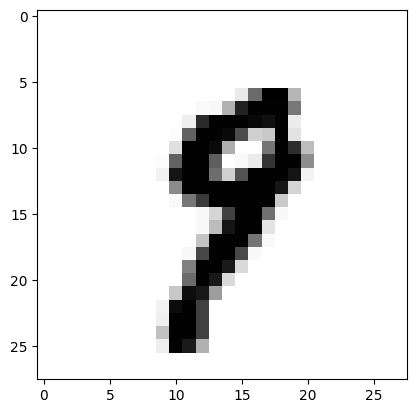

In [105]:
'''
성능 확인을 위해
Ctrl+Enter를 이용하여
반복 실행 해보자!
'''

id = np.random.randint(0,10000)

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

* 틀린 이미지만 확인해보기

id = 6755
다음 그림은 숫자 8 입니다.
모델의 예측 : 9
모델의 카테고리별 확률 : [ 0.  0.  0.  0.  0.  0.  0.  0.  3. 95.]
틀렸어요


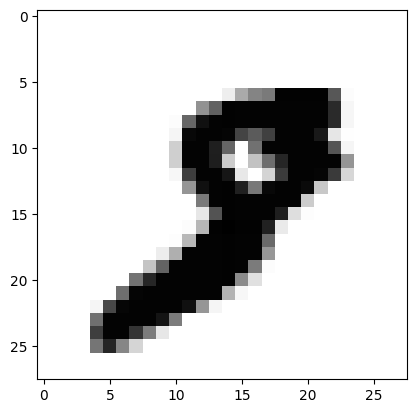

In [106]:
true_false = (test_y.argmax(axis=1) == single_pred_test)
f_id = np.where(true_false == False)[0]
f_n = len(f_id)

id = f_id[np.random.randint(0,f_n)]

print(f'id = {id}')
print(f'다음 그림은 숫자 {test_y.argmax(axis=1)[id]} 입니다.')
print(f'모델의 예측 : {single_pred_test[id]}')
print(f'모델의 카테고리별 확률 : {np.floor(pred_test[id]*100)}')

if test_y.argmax(axis=1)[id] == single_pred_test[id] :
    print('정답입니다')
else :
    print('틀렸어요')

plt.imshow(test_x[id].reshape([28,-1]), cmap='Greys')
plt.show()

# **내가 만든 손글씨 이미지는 어떻게 판단할까?**
---
## **구글 드라이브에 손글씨 이미지를 업로드!**
###**순서**
1. 그림판으로 숫자를 그려서 저장한다.
2. 구글 드라이브 첫 화면에 my_data 라는 폴더를 만든다.
3. my_data 폴더 안에 my_mnist 폴더를 만든다.
4. my_mnist 폴더 안에 1번 과정에서 만든 이미지를 업로드한다.
5. 30초 정도 기다립시다.
6. 아래의 코드들을 실행해본다.

## Connect Colaboratory with my Google Drive
- Colaboratory와 본인의 구글 드라이브를 연결하는 과정
- 아래 코드를 실행하여 폴더가 올바르게 생성 되었는지 확인

In [107]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [108]:
!ls

drive  model1.keras  my_first_save.keras  sample_data


In [109]:
!cd /content/drive/MyDrive/my_data; ls

0.png  1.png  2.png  3.png  4.png  5.png  6.png  7.png	8.png  9.png


## Load Image
- 업로드 한 이미지 하나를 불러와 확인해본다

In [140]:
import glob
from keras.preprocessing import image

In [151]:
files = glob.glob('/content/drive/MyDrive/my_data/new_data/*')
files

['/content/drive/MyDrive/my_data/new_data/8_1.png',
 '/content/drive/MyDrive/my_data/new_data/6_1.png',
 '/content/drive/MyDrive/my_data/new_data/9_1.png',
 '/content/drive/MyDrive/my_data/new_data/7_1.png',
 '/content/drive/MyDrive/my_data/new_data/2_1.png',
 '/content/drive/MyDrive/my_data/new_data/4_1.png',
 '/content/drive/MyDrive/my_data/new_data/5_1.png',
 '/content/drive/MyDrive/my_data/new_data/3_1.png',
 '/content/drive/MyDrive/my_data/new_data/0_1.png',
 '/content/drive/MyDrive/my_data/new_data/1_1.png']

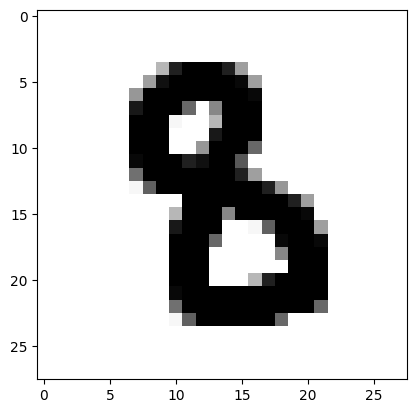

In [152]:
img = image.load_img(files[0], color_mode='grayscale', target_size=(28,28) )
img = image.img_to_array(img)

plt.imshow(img.reshape(img.shape[0], img.shape[1]), cmap='gray')
plt.show()

In [153]:
img = 255-img

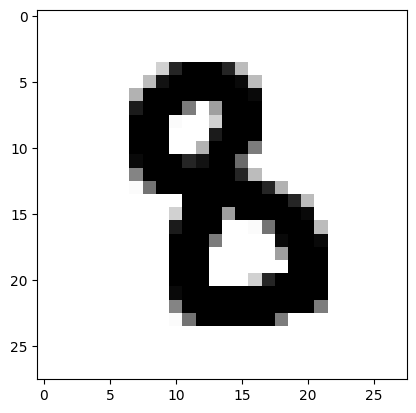

In [154]:
plt.imshow(img.reshape(img.shape[0],img.shape[1]), cmap='Greys'  )
plt.show()

In [155]:
model.predict(img.reshape((-1,28,28,1)))[0].argmax()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


8

## Load Images
- 업로드 한 이미지 전체를 확인해본다

In [156]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [157]:
images.shape

(10, 28, 28, 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


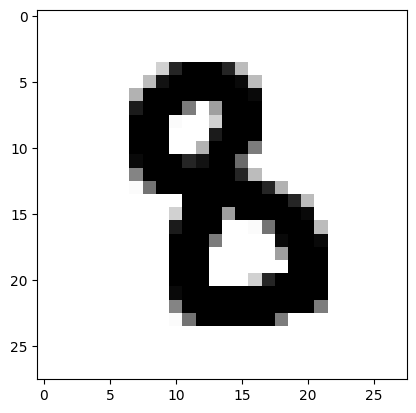

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


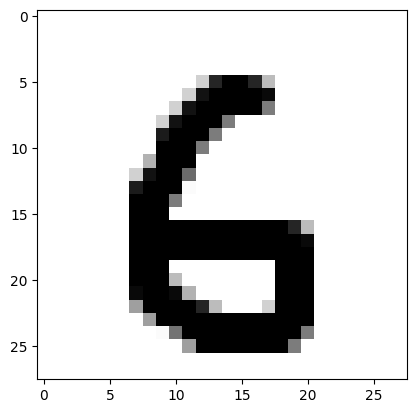

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


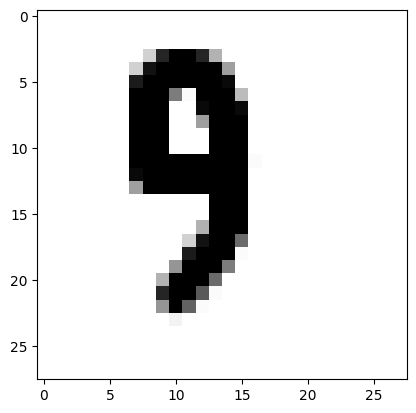

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


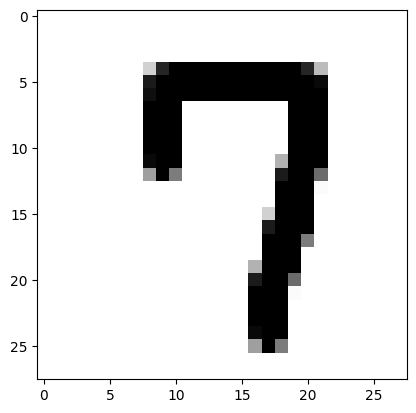

모델의 예측 : 2
모델의 카테고리별 확률 : [  0.   0. 100.   0.   0.   0.   0.   0.   0.   0.]


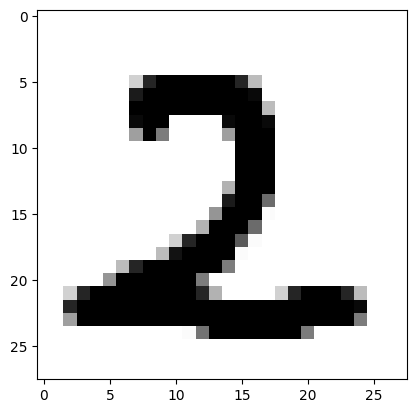

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


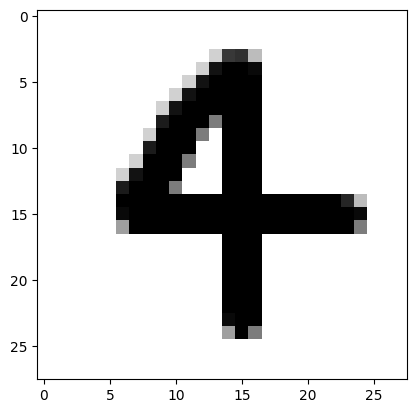

모델의 예측 : 5
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0. 100.   0.   0.   0.   0.]


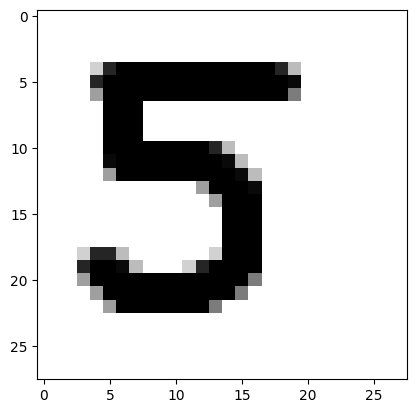

모델의 예측 : 3
모델의 카테고리별 확률 : [  0.   0.   0. 100.   0.   0.   0.   0.   0.   0.]


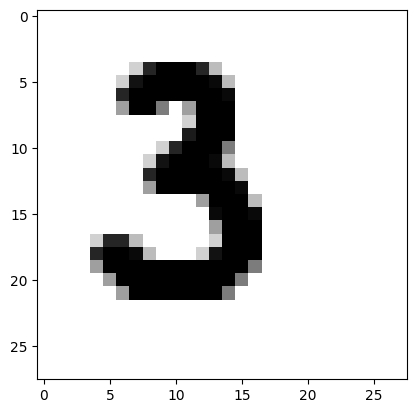

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


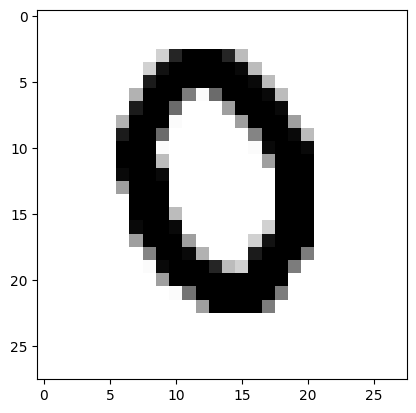

모델의 예측 : 8
모델의 카테고리별 확률 : [  0.   0.   0.   0.   0.   0.   0.   0. 100.   0.]


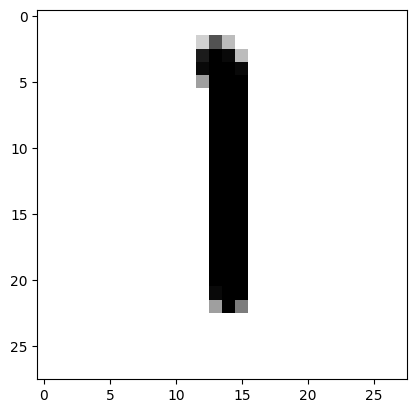

In [158]:
pred = model.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()

---

# Extra: image_dataset_from_directory
## 이미 내가 이미지 데이터를 클래스별로 정리한 상태라면?
---
## **순서**
1. 구글 드라이브에 my_data/my_mnist2 폴더를 생성합니다.
2. my_mnist2 폴더 안에 손글씨가 폴더별로 구분되어야 한다.
    - ex) 0에 대한 이미지면 my_data/my_mnist2/0/0_1.jpg
    - ex) 1에 대한 이미지면 my_data/my_mnist2/1/1_1.jpg

In [149]:
from keras.utils import image_dataset_from_directory

In [150]:
# idfd_train, idfd_valid = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
#                                                       label_mode='categorical',
#                                                       color_mode='grayscale',
#                                                       image_size=(28,28),
#                                                       seed=2024,
#                                                       validation_split=0.2,
#                                                       subset='both'
#                                                       )

idfd_train = image_dataset_from_directory('/content/drive/MyDrive/my_data/my_mnist2',
                                                      label_mode='categorical',
                                                      color_mode='grayscale',
                                                      image_size=(28,28),
                                                      )

NotFoundError: Could not find directory /content/drive/MyDrive/my_data/my_mnist2

In [ ]:
clear_session()

model5 = keras.models.load_model('./model1.keras')

# model5.summary()

In [ ]:
model5.fit(idfd_train,
        #    validation_data=idfd_valid,
           epochs=100, verbose=1)

In [ ]:
images = []

for path in files :
    img = image.load_img(path, color_mode='grayscale', target_size=(28,28) )
    img = image.img_to_array(img)
    img = 255-img
    images.append(img)

images = np.array(images)

In [ ]:
images.shape

In [ ]:
pred = model5.predict(images)

for i in range(images.shape[0]) :
    print('====================================')
    print(f'모델의 예측 : {pred[i].argmax()}')
    print(f'모델의 카테고리별 확률 : {np.floor(pred[i]*100)}')

    plt.imshow(images[i].reshape(28,28) , cmap='Greys')
    plt.show()